<a href="https://colab.research.google.com/github/radipta25/coursera/blob/main/ocr_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files, drive
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import zipfile
from tensorflow import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [2]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
test_local_zip = '/content/drive/MyDrive/ML BANGKIT/handwriten.csv.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/dataset')

zip_ref.close()

In [5]:
os.listdir('/tmp/dataset/')

['A_Z Handwritten Data', 'A_Z Handwritten Data.csv']

In [6]:
alphabet_data = '/tmp/dataset/A_Z Handwritten Data.csv'
aZ_data = []
aZ_labels = []

files = open(alphabet_data)

for row in files:
  row  = row.split(',')

  #append labels. Row 0 = labels / header
  aZ_labels.append(int(row[0]))

  #append labels. Row 1:
  image = np.array([int(x) for x in row[1:]], dtype="uint8")
  img = image.reshape((28,28))
  aZ_data.append(img)

aZ_labels = np.array(aZ_labels, dtype = 'int')
aZ_data = np.array(aZ_data, dtype='float32')

In [7]:
print(len(aZ_labels))
print(len(aZ_data))

372451
372451


In [8]:
print(aZ_labels[-1])
print(aZ_data[-1].shape)

25
(28, 28)


In [9]:
(train_digit_data, train_digit_labels), (test_digit_data, test_digit_labels) = mnist.load_data()

digit_data = np.vstack([train_digit_data, test_digit_data])
digit_labels = np.hstack([train_digit_labels, test_digit_labels])
     

11490434/11490434 [==============================] - 0s 0us/step


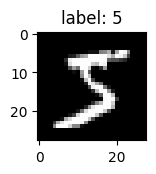

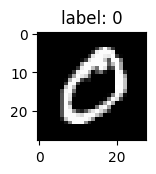

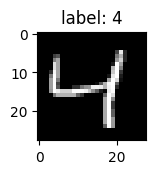

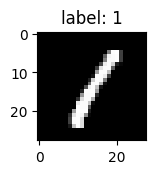

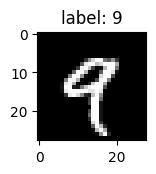

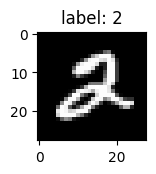

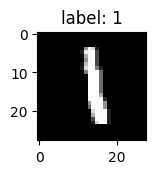

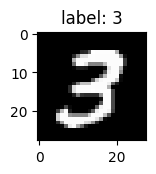

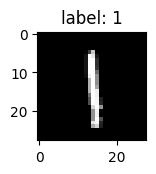

In [10]:
from matplotlib import pyplot
for i in range(9):  
   pyplot.subplot(330 + 1 + i)
   pyplot.title('label: {}'.format(digit_labels[i]))
   pyplot.imshow(digit_data[i], cmap=pyplot.get_cmap('gray'))
   pyplot.show()

In [11]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 

aZ_labels += 10

# stack the A-Z data and labels with the MNIST digits data and labels

data = np.vstack([aZ_data, digit_data])
labels = np.hstack([aZ_labels, digit_labels])

# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

data = np.expand_dims(data, axis=-1)
data /= 255.0

In [12]:
print(len(aZ_labels))

372451


In [13]:
print("amount of data: {}".format(len(data)))
print("amount of labels: {}".format(len(labels)))
print("amount of class: {}".format(len(np.unique(labels))))

amount of data: 442451
amount of labels: 442451
amount of class: 36


In [14]:
#split data
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
print("amount of train data: {}".format(len(x_train)))
print("amount of test data: {}".format(len(x_test)))
print("shape of data: {}".format(x_train.shape[1:4]))
     

amount of train data: 353960
amount of test data: 88491
shape of data: (32, 32, 1)


In [16]:
img_size = 32
EPOCHS = 100
INIT_LR = 1e-1
batch_size = 128

In [17]:
# construct the image generator for data augmentation
train_aug = ImageDataGenerator(
  rescale = 1./255,
  rotation_range=10,
  zoom_range=0.05,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.15,
  horizontal_flip=False,
  fill_mode="nearest")

valid_aug = ImageDataGenerator(
    rescale = 1./255
)
train_datagen = train_aug.flow(x_train, y_train, batch_size = batch_size)

validation_datagen = valid_aug.flow(x_test, y_test, batch_size = batch_size)

In [18]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32,(3,3), activation ='relu', input_shape=(32,32,1)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation ='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation ='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
 
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dense(36, activation='softmax'),

])
model.build(input_shape = (None, 32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [19]:
# model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
# # (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [20]:
History = model.fit(
train_datagen,
validation_data=validation_datagen,
steps_per_epoch=len(x_train) // batch_size, 
epochs=EPOCHS,
verbose=2)

Epoch 1/100
2765/2765 - 157s - loss: 1.3145 - accuracy: 0.6317 - val_loss: 0.3141 - val_accuracy: 0.9092 - 157s/epoch - 57ms/step
Epoch 2/100
2765/2765 - 147s - loss: 0.5326 - accuracy: 0.8399 - val_loss: 0.2197 - val_accuracy: 0.9328 - 147s/epoch - 53ms/step
Epoch 3/100
2765/2765 - 140s - loss: 0.4250 - accuracy: 0.8709 - val_loss: 0.1830 - val_accuracy: 0.9434 - 140s/epoch - 51ms/step
Epoch 4/100
2765/2765 - 141s - loss: 0.3653 - accuracy: 0.8880 - val_loss: 0.1702 - val_accuracy: 0.9469 - 141s/epoch - 51ms/step
Epoch 5/100
2765/2765 - 141s - loss: 0.3310 - accuracy: 0.8983 - val_loss: 0.1536 - val_accuracy: 0.9525 - 141s/epoch - 51ms/step
Epoch 6/100
2765/2765 - 141s - loss: 0.3075 - accuracy: 0.9053 - val_loss: 0.1524 - val_accuracy: 0.9546 - 141s/epoch - 51ms/step
Epoch 7/100
2765/2765 - 147s - loss: 0.2883 - accuracy: 0.9110 - val_loss: 0.1456 - val_accuracy: 0.9556 - 147s/epoch - 53ms/step
Epoch 8/100
2765/2765 - 144s - loss: 0.2759 - accuracy: 0.9148 - val_loss: 0.1368 - val_ac

In [21]:
!mkdir -p ocr_model
model.save('ocr-model-dipta.h5')

In [22]:
model = load_model('ocr-model-dipta.h5')

In [24]:
from google.colab import files
files.download('ocr-model-dipta.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
model.save_weights('modeldipta_weights.h5')

In [26]:
files.download('modeldipta_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>